In [75]:
import numpy as np
import pandas as pd
import ast
import os
import glob
from pathlib import Path
from modeling_parameters.config import (
    PRIM_PARTICLE, 
    THETA,
    COORDINATES_PATH,
    RECONSTRUCTION_GEANT_OUTPUT_DIR,
    MATPLOTLIBRC_PATH,
    CENTRAL_STATIONS,
)


import matplotlib as mpl
mpl.rc_file(MATPLOTLIBRC_PATH)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from modeling_parameters.reconstruction.geant.functions import(
     compute_r,
     rho_model,
)

from functions import (
    plot_two_distributions_by_name,
    plot_single_distribution_by_name,
    plot_single_distribution_Ne,
    plot_two_distributions_Ne,
    ast_df,
    process_df,
)

In [76]:
coordinates_df = pd.read_csv(COORDINATES_PATH)

X_det = np.array(coordinates_df['X'])
Y_det = np.array(coordinates_df['Y'])
Z_det = np.array(coordinates_df['Z'])

In [162]:
folder_path = Path(RECONSTRUCTION_GEANT_OUTPUT_DIR)
files = sorted(f for f in folder_path.iterdir() if f.is_file())

def get_file_by_index(index):
    if 0 <= index < len(files):
        return files[index]
    else:
        return None  

index = 2
file = get_file_by_index(index)

if file is not None:
    print(f"Файл с индексом {index}: {file}")
else:
    print(f"Нет файла с индексом {index}")
file_name = file .stem 
E = int(file_name.split('p')[1][:2]) 

Файл с индексом 2: d:\github\repositories\sdf\modeling_parameters\reconstruction\geant\output\p30\p1630_reconstruction.csv


In [163]:
df = pd.read_csv(file)
ast_df(df)
df.head(1)

,theta,phi,X0,Y0,Ne,s,r,rho,mask,worked_clusters,worked_stations,X0_opt,Y0_opt,Ne_opt,s_opt,loss
0,30.0,250.8111,-3.604914,17.520945,618237.3,1.315695,"[19.509455710440555, 31.362824197602176, 34.14...","[58.26403455036442, 27.092532413761788, 18.710...","[True, True, True, True, True, True, True, Tru...","[1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-1.567724,21.652133,716714.088835,0.842687,0.03087


In [164]:
min_st = 7
top_k = 2

In [165]:
arrays = process_df(df, X_det, Y_det, Z_det, min_stations=min_st, top_k=top_k)

In [170]:
who = 'r'
ymax = .50
limit = 19
bin_width = 5
save = False

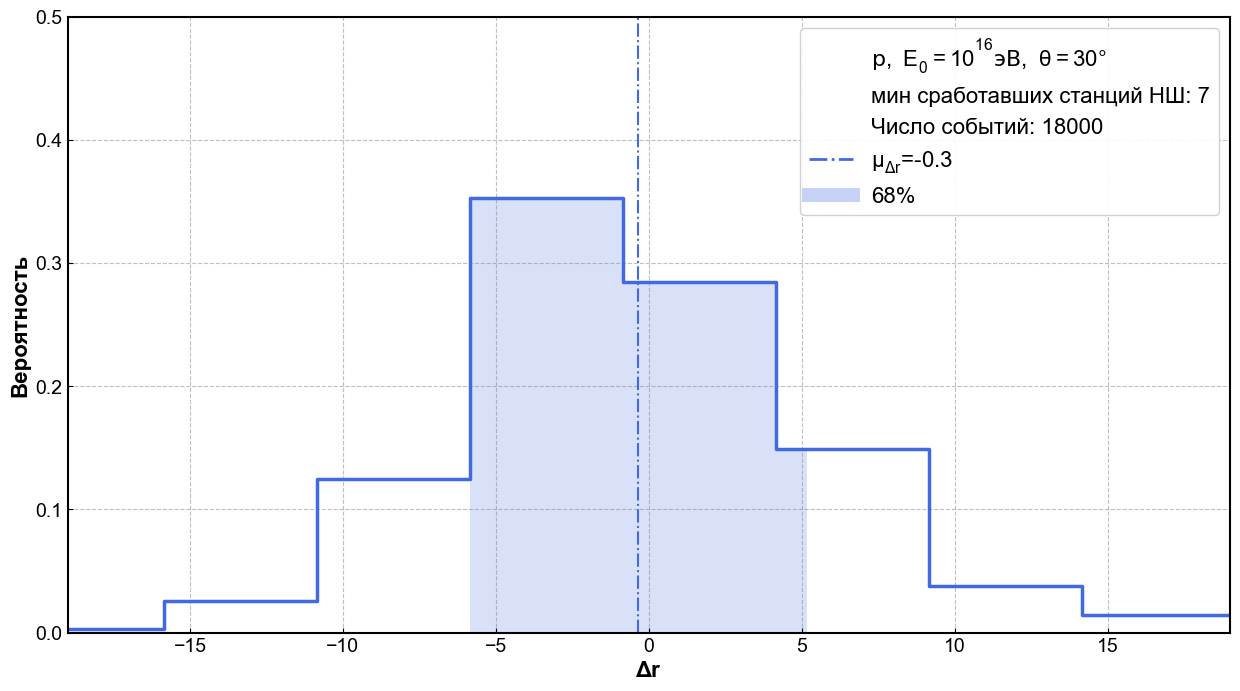

In [171]:
plot_single_distribution_by_name(arrays, who, E, limit, bin_width, min_st, top_k, ymax, save)

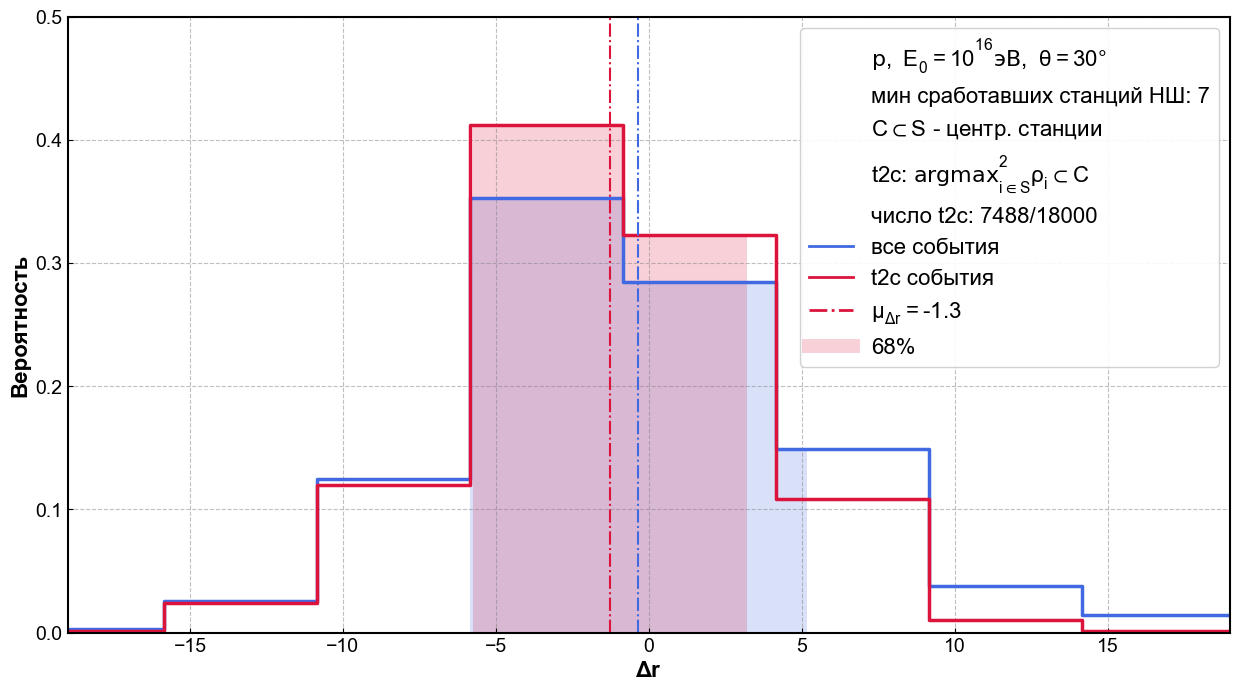

In [172]:
plot_two_distributions_by_name(arrays, who, E, limit, bin_width, min_st, top_k, ymax, save)

## $N_e$

In [185]:
limit = 0.4
ymax = 0.3
bin_width = 0.05
save = False

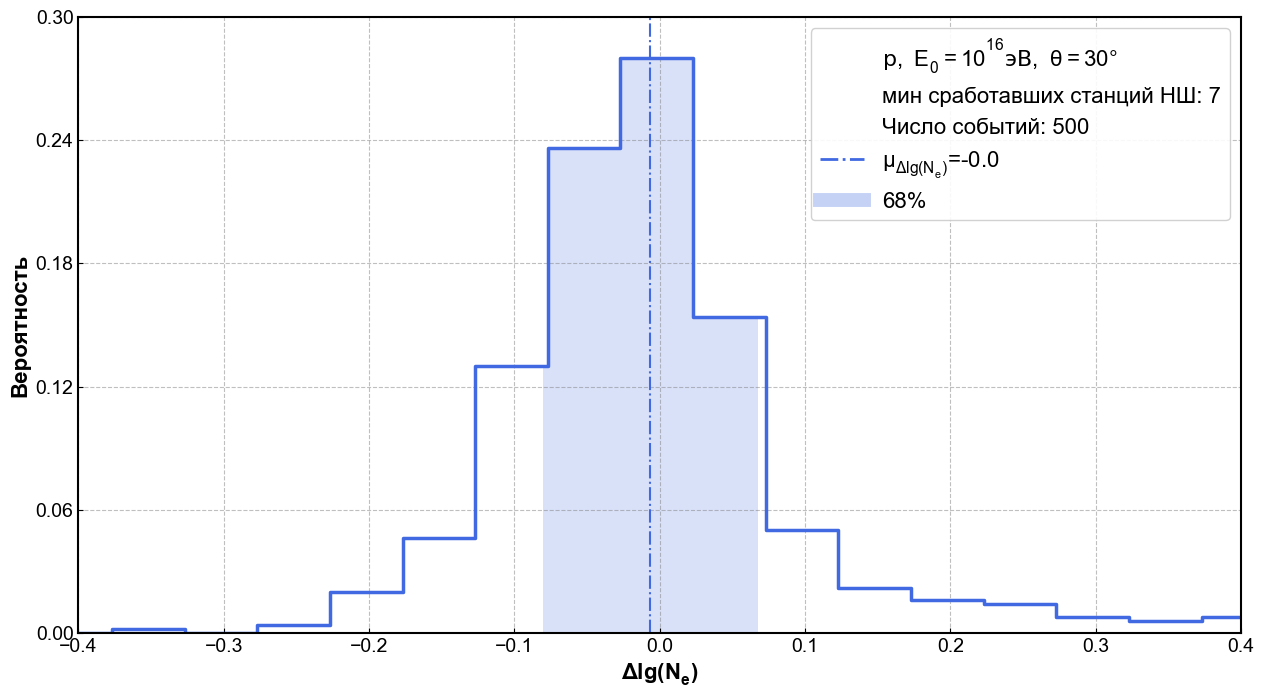

In [186]:
plot_single_distribution_Ne(arrays['Ne_opt'], arrays['Ne'], 'Ne', E, limit, bin_width, min_st, top_k, ymax, save)

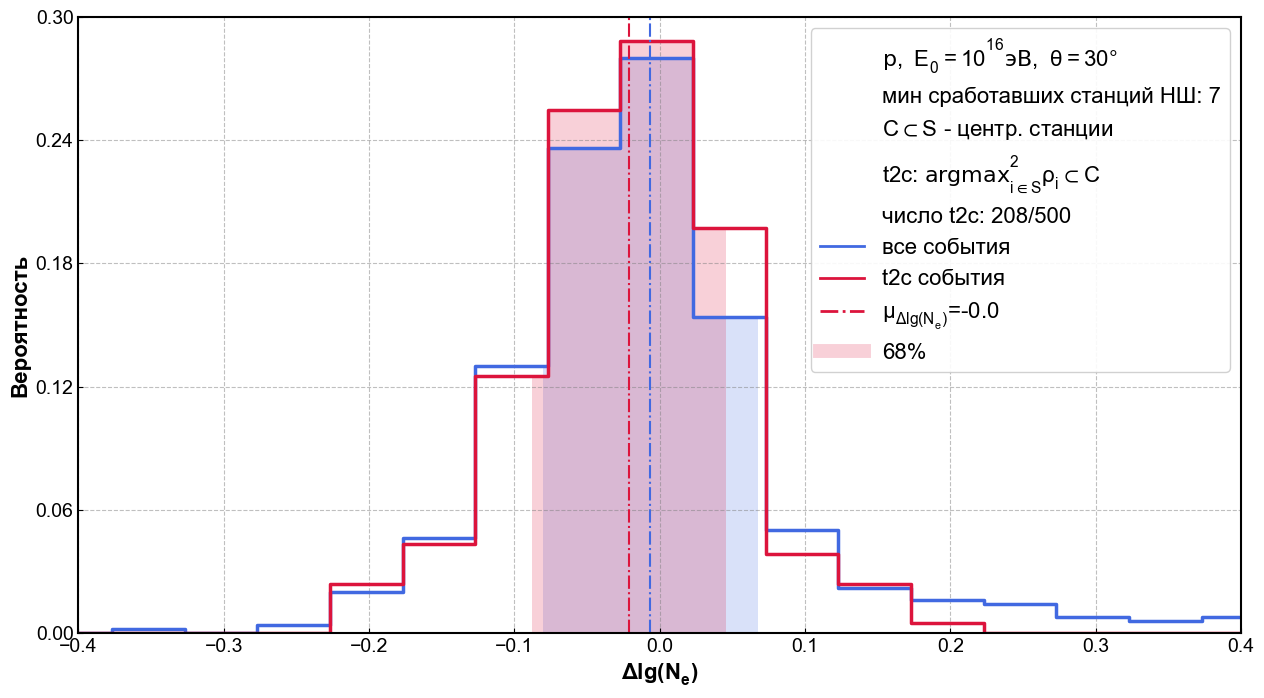

In [187]:
plot_two_distributions_Ne(arrays['Ne_opt'], arrays['Ne'], arrays['t4c_Ne_opt'], arrays['t4c_Ne'], 'Ne', E, limit, bin_width, min_st, top_k, ymax, save)

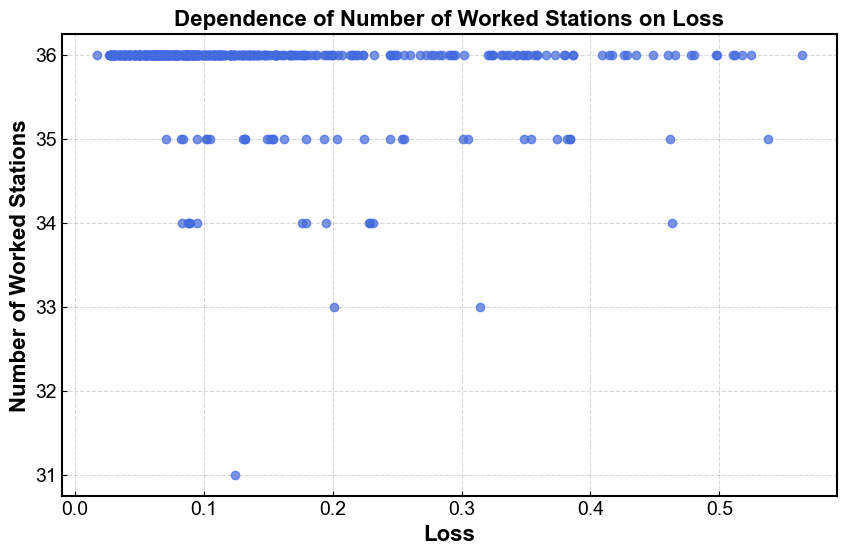

In [183]:
stations_count = np.array([len(stations) for stations in df['worked_stations']])

loss = np.array(df['loss'])
plt.figure(figsize=(10, 6))
plt.scatter(loss, stations_count, color='royalblue', alpha=0.7)
plt.xlabel('Loss')
plt.ylabel('Number of Worked Stations')
plt.title('Dependence of Number of Worked Stations on Loss')
plt.grid(True)
plt.show()

## $\theta = const$ 

$\bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i$

$\sigma = \sqrt{\frac{1}{n - 1} \sum_{i=1}^{n} (x_i - \bar{x})^2}$

$\text{SEM} = \frac{\sigma}{\sqrt{n}}$


In [6]:
files = glob.glob(f"{RECONSTRUCTION_GEANT_OUTPUT_DIR}/*.csv")

def extract_E0(file_path):
    file_name = os.path.basename(file_path)
    return int(file_name.split('p')[1][:2])

df = pd.concat(
    (pd.read_csv(file).assign(E0=extract_E0(file)) for file in files),
    ignore_index=True
)

In [23]:
df.head(1)

,theta,phi,X0,Y0,Ne,s,r,rho,mask,worked_clusters,worked_stations,X0_opt,Y0_opt,Ne_opt,s_opt,loss,E0,delta_s,E_real
0,30.0,103.14099,28.654863,-1.643812,975.24255,1.406081,"[52.132974028244945, 64.30169345610112, 65.869...","[1.1284036970720057, 0.7790800456593675, 0.391...","[False, False, False, False, False, False, Fal...",[8],"[28, 29, 30]",45.11941,37.804688,147793.281344,0.359605,1.052842e-32,14,-1.046476,100000000000000


In [24]:
df["E_real"] = 10 ** df["E0"] 

df["delta_s"] = df["s_opt"] - df["s"]
stats_s = df.groupby("E_real")["delta_s"].agg(["mean", "std", "count"])
stats_s["sem"] = stats_s["std"] / stats_s["count"]**0.5

df["delta_X"] = df["X0_opt"] - df["X0"]
stats_x = df.groupby("E_real")["delta_X"].agg(["mean", "std", "count"])
stats_x["sem"] = stats_x["std"] / stats_x["count"]**0.5

df["delta_Y"] = df["Y0_opt"] - df["Y0"]
stats_y = df.groupby("E_real")["delta_Y"].agg(["mean", "std", "count"])
stats_y["sem"] = stats_y["std"] / stats_y["count"]**0.5

df["delta_logNe"] = np.log10(df["Ne_opt"] / df["Ne"])
stats_ne = df.groupby("E_real")["delta_logNe"].agg(["mean", "std", "count"])
stats_ne["sem"] = stats_ne["std"] / stats_ne["count"]**0.5 

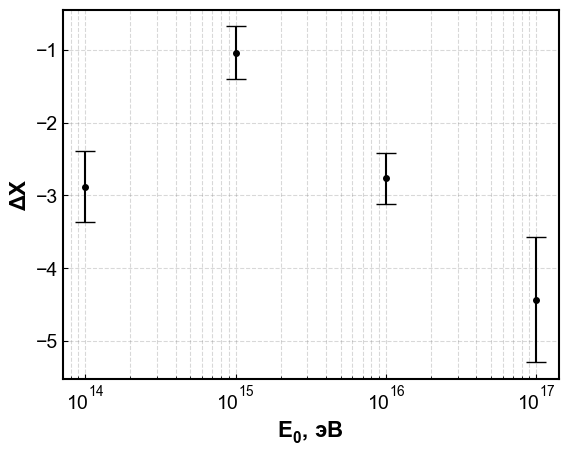

In [59]:
plt.errorbar(stats_x.index, stats_x["mean"], yerr=stats_x["sem"], fmt='o', 
             capsize=7, markersize=4, color='black')
plt.xscale('log')
plt.xlabel(r"$E_0$, эВ")
plt.ylabel(r"$\Delta X$")
plt.grid(True, which='both', ls='--')
plt.show()

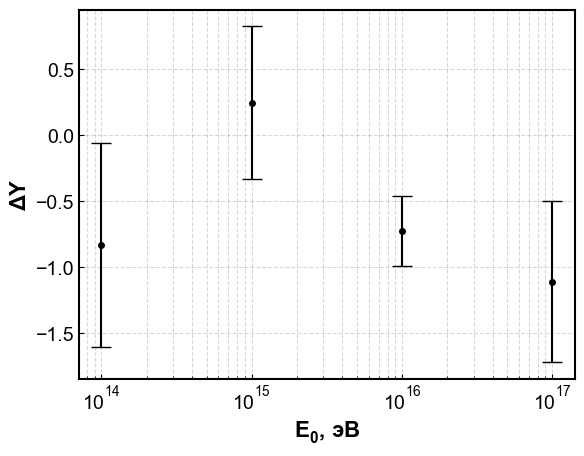

In [60]:
plt.errorbar(stats_y.index, stats_y["mean"], yerr=stats_y["sem"], fmt='o', 
             capsize=7, markersize=4, color='black')
plt.xscale('log')
plt.xlabel(r"$E_0$, эВ")
plt.ylabel(r"$\Delta Y$")
plt.grid(True, which='both', ls='--')
plt.show()

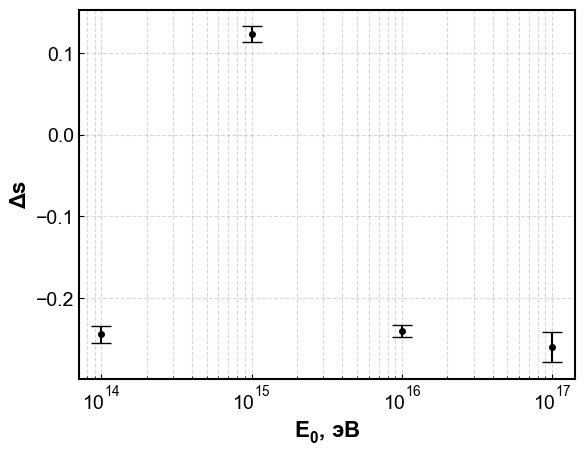

In [48]:
plt.errorbar(stats_s.index, stats_s["mean"], yerr=stats_s["sem"], fmt='o', 
             capsize=7, markersize=4, color='black')
plt.xscale('log')
plt.xlabel(r"$E_0$, эВ")
plt.ylabel(r"$\Delta s$")
plt.grid(True, which='both', ls='--')
plt.show()

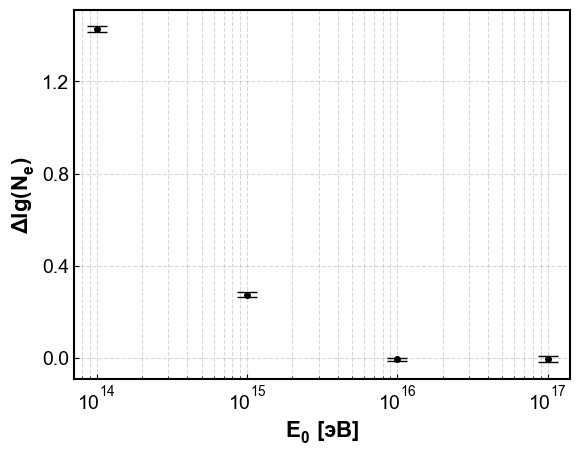

In [55]:
plt.errorbar(stats_ne.index, stats_ne["mean"], yerr=stats_ne["sem"], fmt='o', 
             capsize=7, markersize=4, color='black')
plt.xscale('log')

plt.xlabel(r"$E_0$ [эВ]")
plt.ylabel(r"$\Delta lg (N_e)$")
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=5)) 
plt.grid(True, which='both', ls='--')
plt.show()


In [ ]:
df['r'] = df.apply(lambda row: compute_r(row['X0'], row['Y0'], -18, row['theta'], row['phi'], X_det, Y_det, Z_det), axis=1)
df['r_opt'] = df.apply(lambda row: compute_r(row['X0_opt'], row['Y0_opt'], -18, row['theta'], row['phi'], X_det, Y_det, Z_det), axis=1)

df['delta_r'] = df['r_opt'] - df['r']

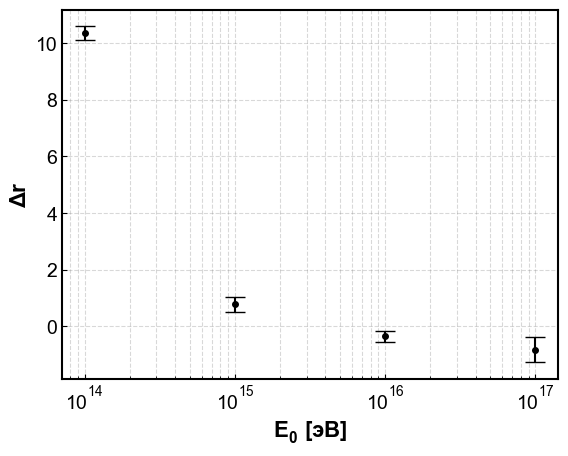

In [67]:
df['r'] = df['r'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)
df['r_opt'] = df['r_opt'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)
df['delta_r'] = df['r_opt'] - df['r']

stats = df.groupby('E_real')['delta_r'].agg(['mean', 'std', 'count'])
stats['sem'] = stats['std'] / np.sqrt(stats['count'])

plt.errorbar(stats.index, stats["mean"], yerr=stats["sem"], fmt='o', 
             capsize=7, markersize=4, color='black')
plt.xscale('log')

plt.xlabel(r"$E_0$ [эВ]")
plt.ylabel(r"$\Delta r$")
plt.grid(True, which='both', ls='--')
plt.show()